In [1]:
import pycocotools

In [2]:
import numpy as np

In [3]:
import os

In [4]:
! git clone https://github.com/experiencor/raccoon_dataset.git

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Total 646 (delta 0), reused 0 (delta 0), pack-reused 646
Receiving objects: 100% (646/646), 48.00 MiB | 19.73 MiB/s, done.
Resolving deltas: 100% (412/412), done.


In [5]:
os.getcwd()

'/content'

In [6]:
%mkdir object_detection

In [7]:
cd /content/object_detection

/content/object_detection


In [8]:
os.getcwd()

'/content/object_detection'

In [9]:
%%bash
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [38]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from PIL import ImageDraw
import pandas as pd
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [11]:
def parse_one_annot(path_to_data_file, filename):
   data = pd.read_csv(path_to_data_file)
   boxes_array = data[data["filename"] == filename][["xmin", "ymin",        
   "xmax", "ymax"]].values
   
   return boxes_array

In [13]:
class RaccoonDataset(torch.utils.data.Dataset):
  def __init__(self, root, data_file, transforms=None):
    self.root = root
    self.transforms = transforms
    self.imgs = sorted(os.listdir(os.path.join(root, "images")))
    self.path_to_data_file = data_file
  def __getitem__(self, idx):
    # load images and bounding boxes
    img_path = os.path.join(self.root, "images", self.imgs[idx])
    img = Image.open(img_path).convert("RGB")
    box_list = parse_one_annot(self.path_to_data_file,self.imgs[idx])
    boxes = torch.as_tensor(box_list, dtype=torch.float32)
    num_objs = len(box_list)
    # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd
    if self.transforms is not None:
      img, target = self.transforms(img, target)
    return img, target
  def __len__(self):
    return len(self.imgs)

In [14]:
dataset = RaccoonDataset(root= "/content/raccoon_dataset",data_file= "/content/raccoon_dataset/data/raccoon_labels.csv")

In [15]:
dataset.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=650x417 at 0x7F4527039F60>,
 {'area': tensor([141120.]),
  'boxes': tensor([[ 81.,  88., 522., 408.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1])})

In [22]:
def get_model(num_classes):
  # load an object detection model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new on
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
   
  return model

In [17]:
def get_transform(train):
   transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
   transforms.append(T.ToTensor())
   if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
      transforms.append(T.RandomHorizontalFlip(0.5))
   return T.Compose(transforms)

In [18]:
# use our dataset and defined transformations
dataset = RaccoonDataset(root= "/content/raccoon_dataset",data_file= "/content/raccoon_dataset/data/raccoon_labels.csv",transforms = get_transform(train=True))
dataset_test = RaccoonDataset(root= "/content//raccoon_dataset",data_file= "/content/raccoon_dataset/data/raccoon_labels.csv",transforms = get_transform(train=False))
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4,collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4,collate_fn=utils.collate_fn)
print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 200 examples, 160 are training and 40 testing


In [19]:
torch.cuda.is_available()

True

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - raccoon and not racoon
num_classes = 2
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [28]:
# let's train it for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
   # train for one epoch, printing every 10 iterations
   train_one_epoch(model, optimizer, data_loader, device, epoch,print_freq=10)
# update the learning rate
   lr_scheduler.step()
   # evaluate on the test dataset
   evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [ 0/80]  eta: 0:02:37  lr: 0.000068  loss: 1.4309 (1.4309)  loss_classifier: 1.2743 (1.2743)  loss_box_reg: 0.1406 (0.1406)  loss_objectness: 0.0063 (0.0063)  loss_rpn_box_reg: 0.0097 (0.0097)  time: 1.9724  data: 0.3603  max mem: 2339
Epoch: [0]  [10/80]  eta: 0:00:49  lr: 0.000701  loss: 0.8025 (0.8118)  loss_classifier: 0.6697 (0.6687)  loss_box_reg: 0.1200 (0.1283)  loss_objectness: 0.0010 (0.0022)  loss_rpn_box_reg: 0.0077 (0.0126)  time: 0.7035  data: 0.0385  max mem: 3689
Epoch: [0]  [20/80]  eta: 0:00:36  lr: 0.001333  loss: 0.3034 (0.5697)  loss_classifier: 0.1538 (0.4218)  loss_box_reg: 0.1209 (0.1319)  loss_objectness: 0.0012 (0.0028)  loss_rpn_box_reg: 0.0077 (0.0133)  time: 0.5486  data: 0.0065  max mem: 3689
Epoch: [0]  [30/80]  eta: 0:00:30  lr: 0.001965  loss: 0.2706 (0.4751)  loss_classifier: 0.1222 (0.3227)  loss_box_reg: 0.1303 (0.1352)  loss_objectness: 0.0025 (0.0045)  loss_rpn_box_reg: 0.0077 (0.0127)  time: 0.5524  data: 0.0066  max mem: 4401
Epoch: [

In [30]:
os.getcwd()

'/content/object_detection'

In [31]:
os.mkdir("/raccoon/")
torch.save(model.state_dict(), "/raccoon/model")

In [33]:
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load("/raccoon/model"))

<All keys matched successfully>

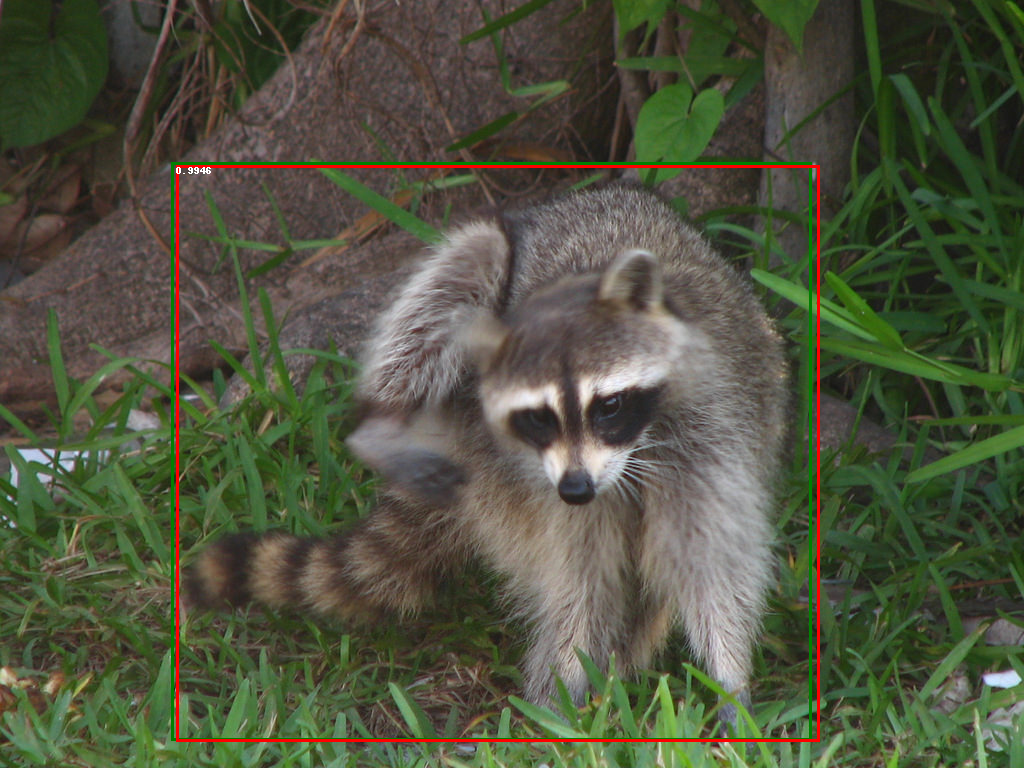

In [44]:
idx = 0
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
#put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
  prediction = loaded_model([img])
  image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
  draw = ImageDraw.Draw(image)
# draw groundtruth
for elem in range(len(label_boxes)):
   draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),(label_boxes[elem][2], label_boxes[elem][3])],outline ="green", width =3)
for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),decimals= 4)
   if score > 0.8:
     draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])],outline ="red", width =3)
     draw.text((boxes[0], boxes[1]), text = str(score))
image